## Задача предсказания отмены бронирования

Данные: https://www.kaggle.com/jessemostipak/hotel-booking-demand

In [1]:
# отключение ворнингов
import warnings
warnings.filterwarnings('ignore')


# импортирую библиотеки
import collections
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             auc, classification_report,
                             plot_roc_curve, roc_auc_score,
                             roc_curve, precision_score,
                             recall_score)

from sklearn.model_selection import (cross_val_score, learning_curve,
                                     GridSearchCV, StratifiedKFold,
                                     RandomizedSearchCV, train_test_split,
                                     validation_curve)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import seaborn as sns

In [2]:
# настройки отображения строк и столбцов в пандас
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# настройка размеров графиков
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
sns.set(style='whitegrid', rc={'figure.figsize':(12, 8), 'lines.linewidth': 3})


# настройка стиля графиков
plt.style.use('ggplot')
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# чтение данных

df = pd.read_csv('data/hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## 1. EDA

Взгляну на распределение целевой переменной:

Доля отмен бронирований  0.3704


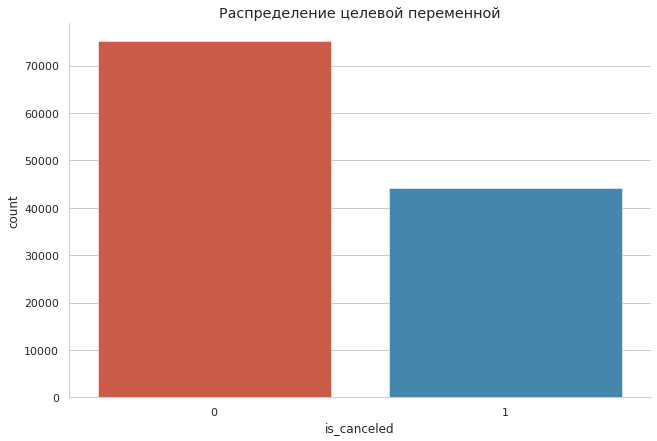

In [4]:
cancel_ratio = df['is_canceled'].mean()

print(f'Доля отмен бронирований {cancel_ratio: .4f}')

# визуально оценю распределение целевой переменной
sns.catplot(x='is_canceled', kind='count', data=df, orient='v', aspect=1.5, height=6)
plt.title('Распределение целевой переменной');

In [5]:
# выведу долю пропусков по столбцам

def missing_values(data):
    """
    Возвращает только колонки с пропусками:
    - общее число пропущенных значений
    - доля пропусков
    """
    missing = pd.DataFrame(df.isnull().sum())
    missing['% of Total Values'] = 100 * df.isnull().sum() / len(df)
    missing.rename(columns = {0 : 'Missing Values'}, inplace=True)
    missing.sort_values(by='% of Total Values', ascending=False, inplace=True)
    missing = missing[missing['Missing Values']>0]
    
    return missing

In [6]:
missing_values(df)

,Missing Values,% of Total Values
company,112593,94.306893
agent,16340,13.686238
country,488,0.408744
children,4,0.003350


Хорошая новость- пропусков немного.  
Разберемся с тем, что это за признаки, чтобы понять как быть с пропусками: 
- company - id компании, которая сделала бронирование (возможно, это бронирования для сотрудников с командировками)
- agent - id турагенства
- country - cтрана происхождения
- children - наличие детей (подростков)  

In [7]:
def feature_stat(data, feature, target, ylim=None):
    """
    Выводит гистограмму и среднее значение целевой
    по группе.
    Подходит для категориальных переменных
    """
    
    # выводим долю таргета по каждой группе
    print('\033[1m{} stats: \033[0m'.format(feature))
    print()
    for value in sort(df[feature].unique()):
        print('Mean target in group {}: {:.4f}'.format(value, df[df[feature]==value][target].mean()))
        
    x = [i for i in data.groupby(feature)[target].count().index]
    y_cnt = [i for i in data.groupby(feature)[target].count().values]
    y_mean = [i for i in data.groupby(feature)[target].mean().values]
    ind = np.arange(len(data[feature].unique()))
    
    fig, ax1 = plt.subplots()
    ax1.bar(ind, y_cnt, align='center', color='royalblue', width=0.4, alpha=0.8)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('count', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(ind, y_mean, marker= 'o', linestyle='-', color='r', linewidth=5)
    ax2.set_ylabel('Target mean rate', color='r')
    ax2.tick_params('y', colors='r')
    plt.xticks(ind, x)
    plt.title('{} and target'.format(feature))
    ax1.set_xticklabels(x, fontsize=14, rotation=45)
    
    if ylim:
        ax2.set_ylim(ylim)
        
    plt.title('{} and target'.format(feature), fontsize=20)
    plt.grid(False)
    plt.show()

    
def get_columns_types(dataframe):
    cat = [column for column in df.columns if df[column].dtype == 'object']
    num = [column for column in df.columns if column not in cat]
    
    return cat, num

cat, num = get_columns_types(df)

hotel stats: 

Mean target in group City Hotel: 0.4173
Mean target in group Resort Hotel: 0.2776


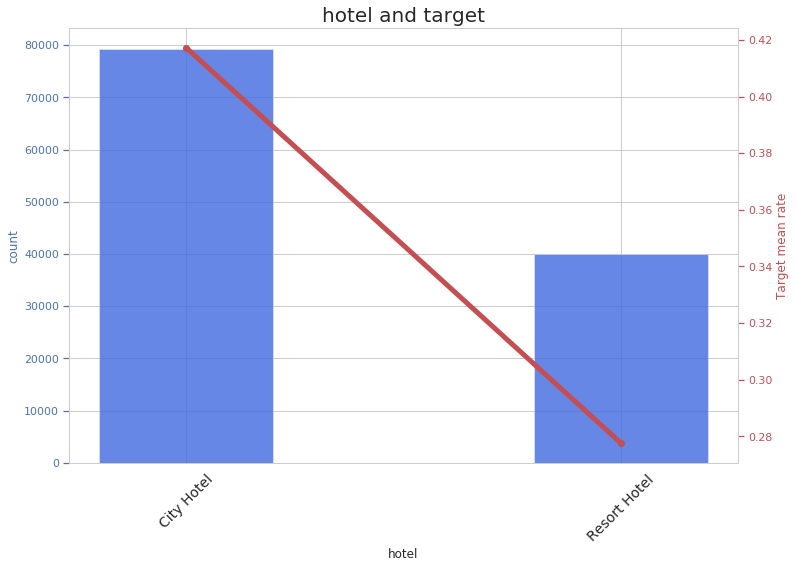

arrival_date_month stats: 

Mean target in group April: 0.4080
Mean target in group August: 0.3775
Mean target in group December: 0.3497
Mean target in group February: 0.3342
Mean target in group January: 0.3048
Mean target in group July: 0.3745
Mean target in group June: 0.4146
Mean target in group March: 0.3215
Mean target in group May: 0.3967
Mean target in group November: 0.3123
Mean target in group October: 0.3805
Mean target in group September: 0.3917


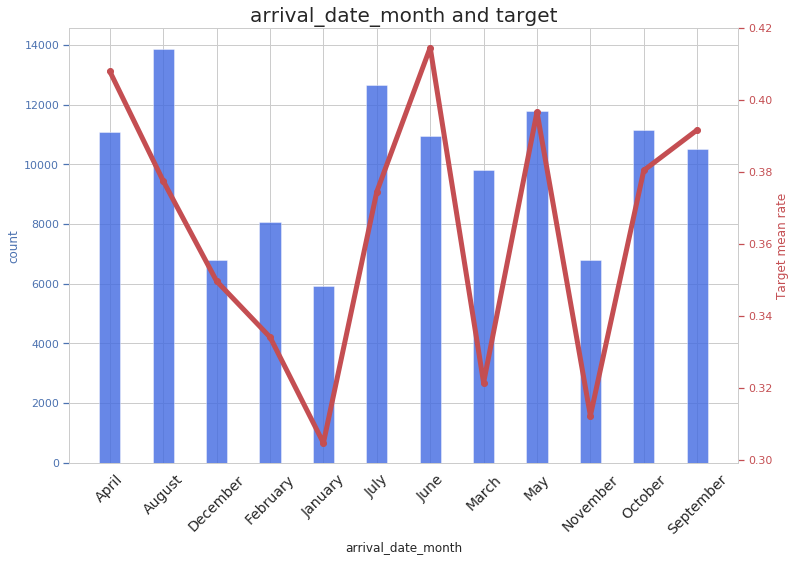

meal stats: 

Mean target in group BB: 0.3738
Mean target in group FB: 0.5990
Mean target in group HB: 0.3446
Mean target in group SC: 0.3724
Mean target in group Undefined: 0.2447


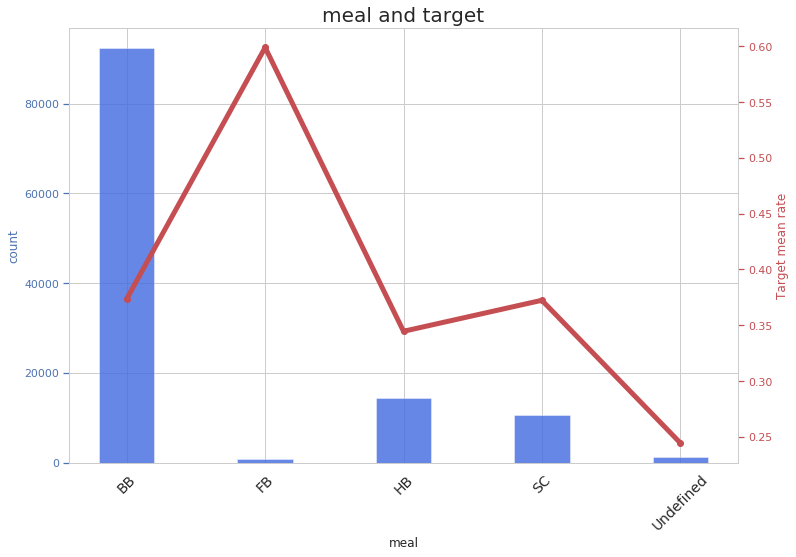

country stats: 

============Something went wrong with country==============
market_segment stats: 

Mean target in group Aviation: 0.2194
Mean target in group Complementary: 0.1306
Mean target in group Corporate: 0.1873
Mean target in group Direct: 0.1534
Mean target in group Groups: 0.6106
Mean target in group Offline TA/TO: 0.3432
Mean target in group Online TA: 0.3672
Mean target in group Undefined: 1.0000


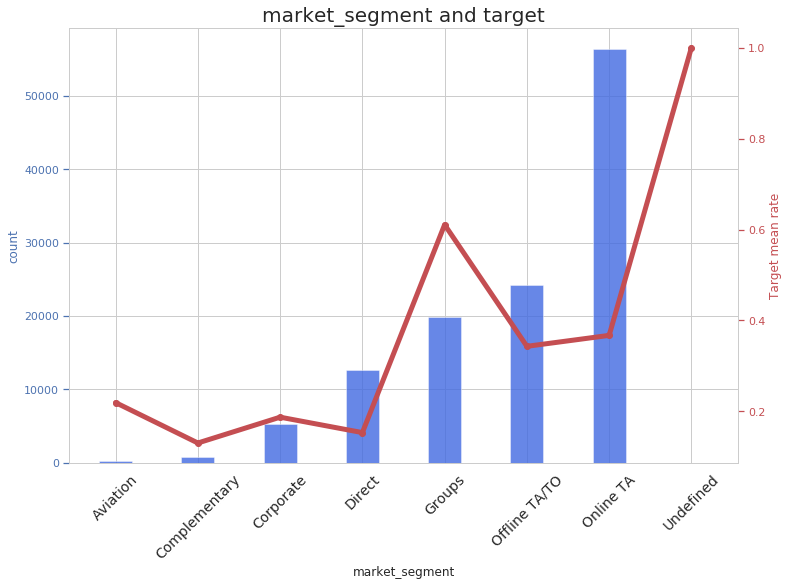

distribution_channel stats: 

Mean target in group Corporate: 0.2208
Mean target in group Direct: 0.1746
Mean target in group GDS: 0.1917
Mean target in group TA/TO: 0.4103
Mean target in group Undefined: 0.8000


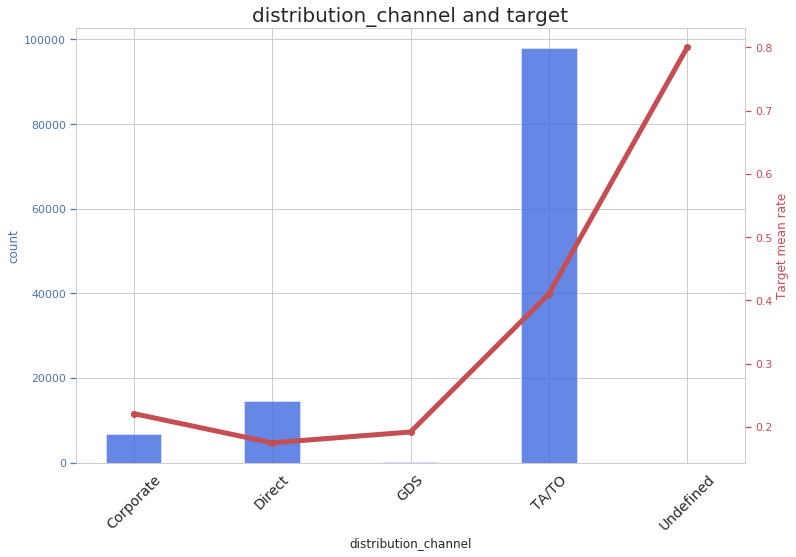

reserved_room_type stats: 

Mean target in group A: 0.3911
Mean target in group B: 0.3292
Mean target in group C: 0.3305
Mean target in group D: 0.3178
Mean target in group E: 0.2929
Mean target in group F: 0.3038
Mean target in group G: 0.3644
Mean target in group H: 0.4077
Mean target in group L: 0.3333
Mean target in group P: 1.0000


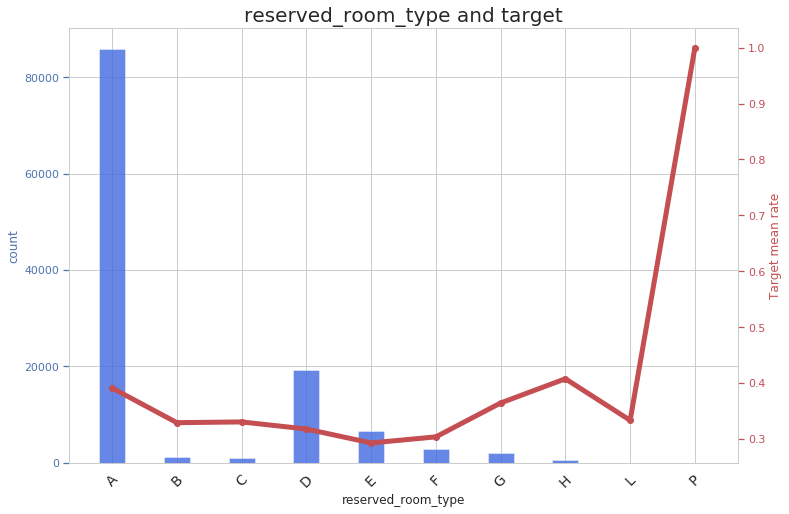

assigned_room_type stats: 

Mean target in group A: 0.4449
Mean target in group B: 0.2367
Mean target in group C: 0.1878
Mean target in group D: 0.2512
Mean target in group E: 0.2521
Mean target in group F: 0.2471
Mean target in group G: 0.3055
Mean target in group H: 0.3525
Mean target in group I: 0.0138
Mean target in group K: 0.0430
Mean target in group L: 1.0000
Mean target in group P: 1.0000


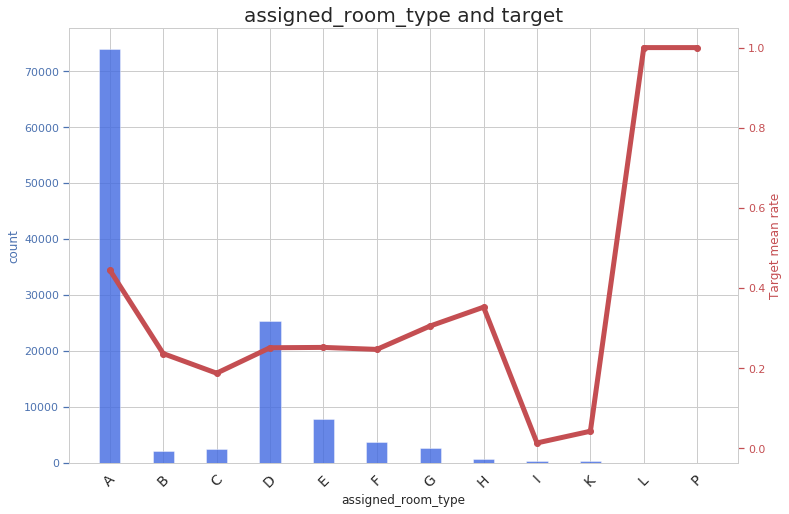

deposit_type stats: 

Mean target in group No Deposit: 0.2838
Mean target in group Non Refund: 0.9936
Mean target in group Refundable: 0.2222


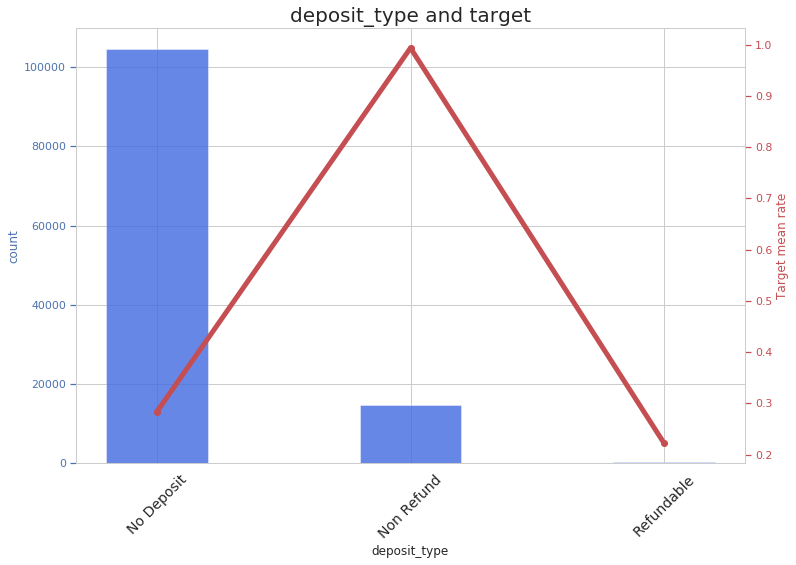

customer_type stats: 

Mean target in group Contract: 0.3096
Mean target in group Group: 0.1023
Mean target in group Transient: 0.4075
Mean target in group Transient-Party: 0.2543


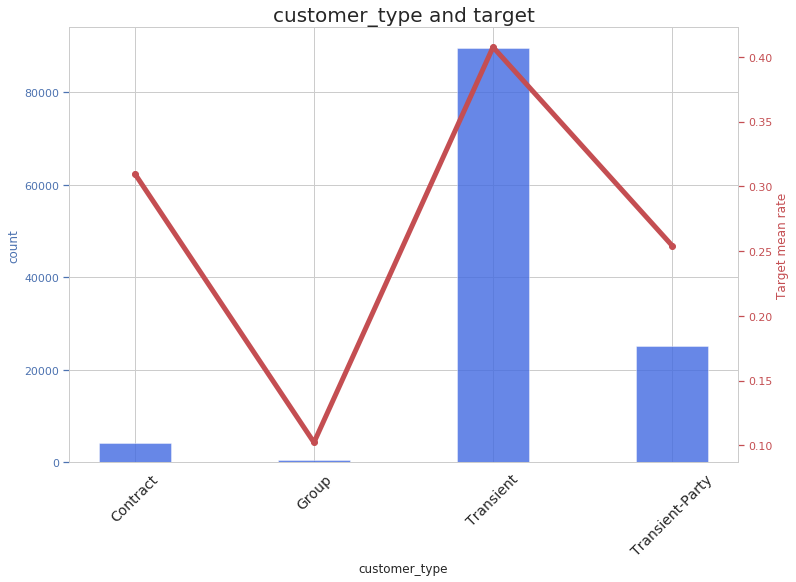

reservation_status stats: 

Mean target in group Canceled: 1.0000
Mean target in group Check-Out: 0.0000
Mean target in group No-Show: 1.0000


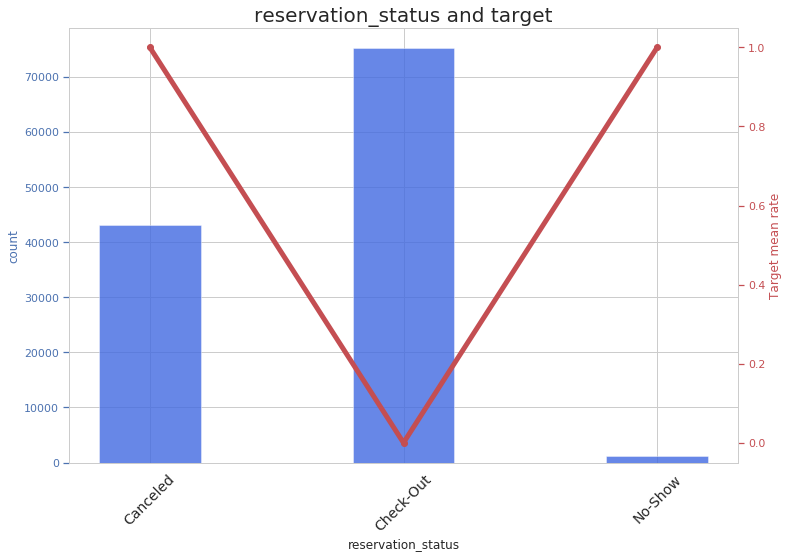

In [8]:
# уберу дату из кат. признаков
cat.remove('reservation_status_date')

for feature in cat:
    try:
        feature_stat(df, feature, 'is_canceled')
    except:
        print(f'============Something went wrong with {feature}==============')

Бросается в глаза:
- очень мало объектов с неизвестным distribution_channel
- схожая проблема для market_segment
- reservation_status - это и есть целевая перменная
- что-то пошло не так со странами


Разберусь с пропусками.

company_null stats: 

Mean target in group 0: 0.3822
Mean target in group 1: 0.1752


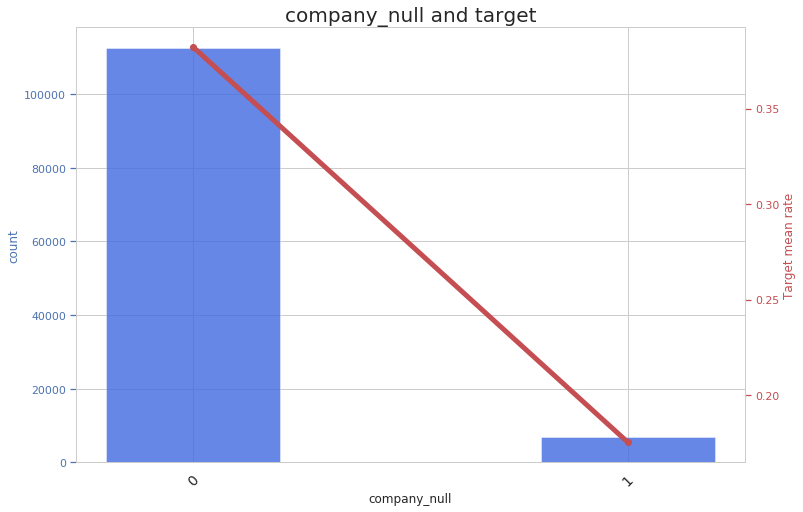

In [9]:
# заведем бинарный признак, 1- непустое поле company, 0- пустое

df['company_null'] = df['company'].apply(lambda x: 0 if np.isnan(x) else 1)
feature_stat(df, 'company_null', 'is_canceled')

Доля отказов у тех, где поле company непустое ниже, чем у тех, у кого пусто.  
Если изначальное предположение о том, что это **командировки**, верно, то такое отличие выглядит логично.  
Удалю признак company, a company_null переименую в **business**:

In [10]:
df = df.drop('company', axis=1)

df.rename(columns={'company_null': 'business'}, inplace=True)

agent_client stats: 

Mean target in group 0: 0.2466
Mean target in group 1: 0.3900


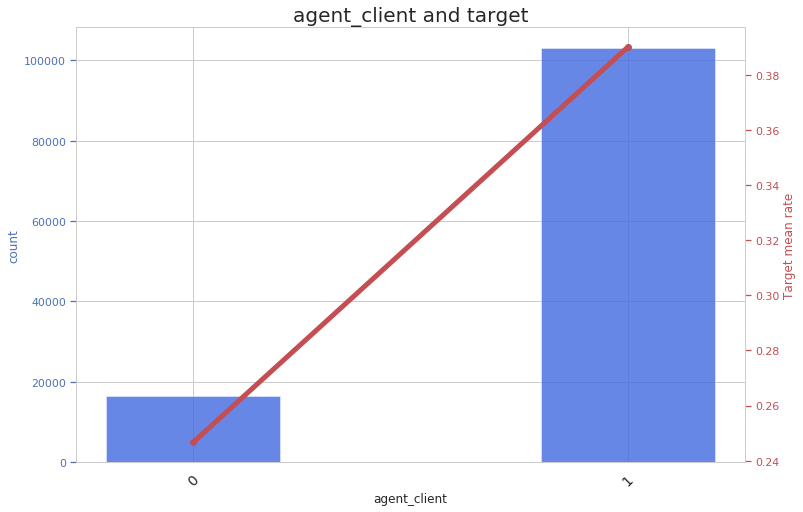

In [11]:
# проделаю тоже само с турагенством

df['agent_client'] = df['agent'].apply(lambda x: 0 if np.isnan(x) else 1)
feature_stat(df, 'agent_client', 'is_canceled')

Здесь ситуация обратная: клиенты турагенств чаще отменяют бронь.  
Оставлю бинарный признак agent_client.

In [12]:
# пропуски заполню нулями, остальные удалю

df['agent'] = df['agent'].fillna(0)
df.dropna(inplace=True)

distribution_channel stats: 

Mean target in group Corporate: 0.2240
Mean target in group Direct: 0.1756
Mean target in group GDS: 0.1917
Mean target in group TA/TO: 0.4105
Mean target in group Undefined: 0.0000


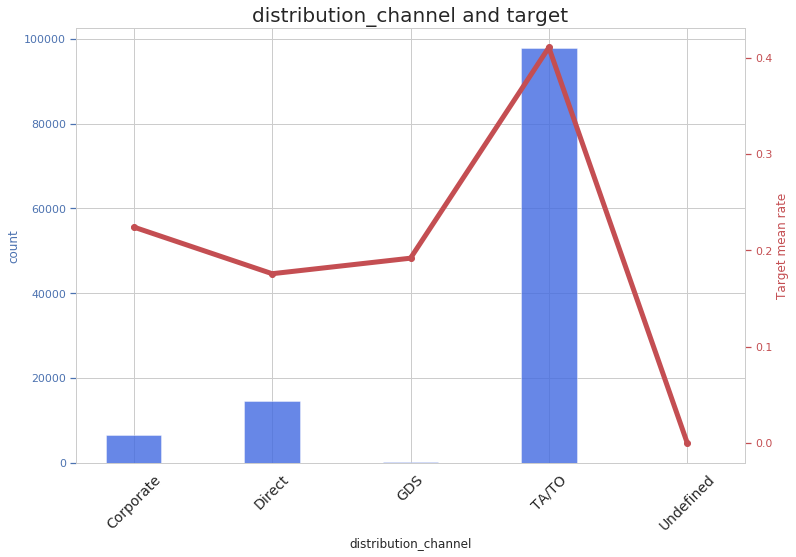

In [13]:
feature_stat(df, 'distribution_channel', 'is_canceled')

In [14]:
df[df['distribution_channel'].isin(['Undefined'])].shape[0]

1

Всего 1 объект с неизвестным distribution_channel.  
Его лучше убрать:

In [15]:
df = df[df['distribution_channel'].isin(['Undefined']) == False]

Удалю reservation_status, тк это leak

In [16]:
df.drop('reservation_status', axis=1, inplace=True)

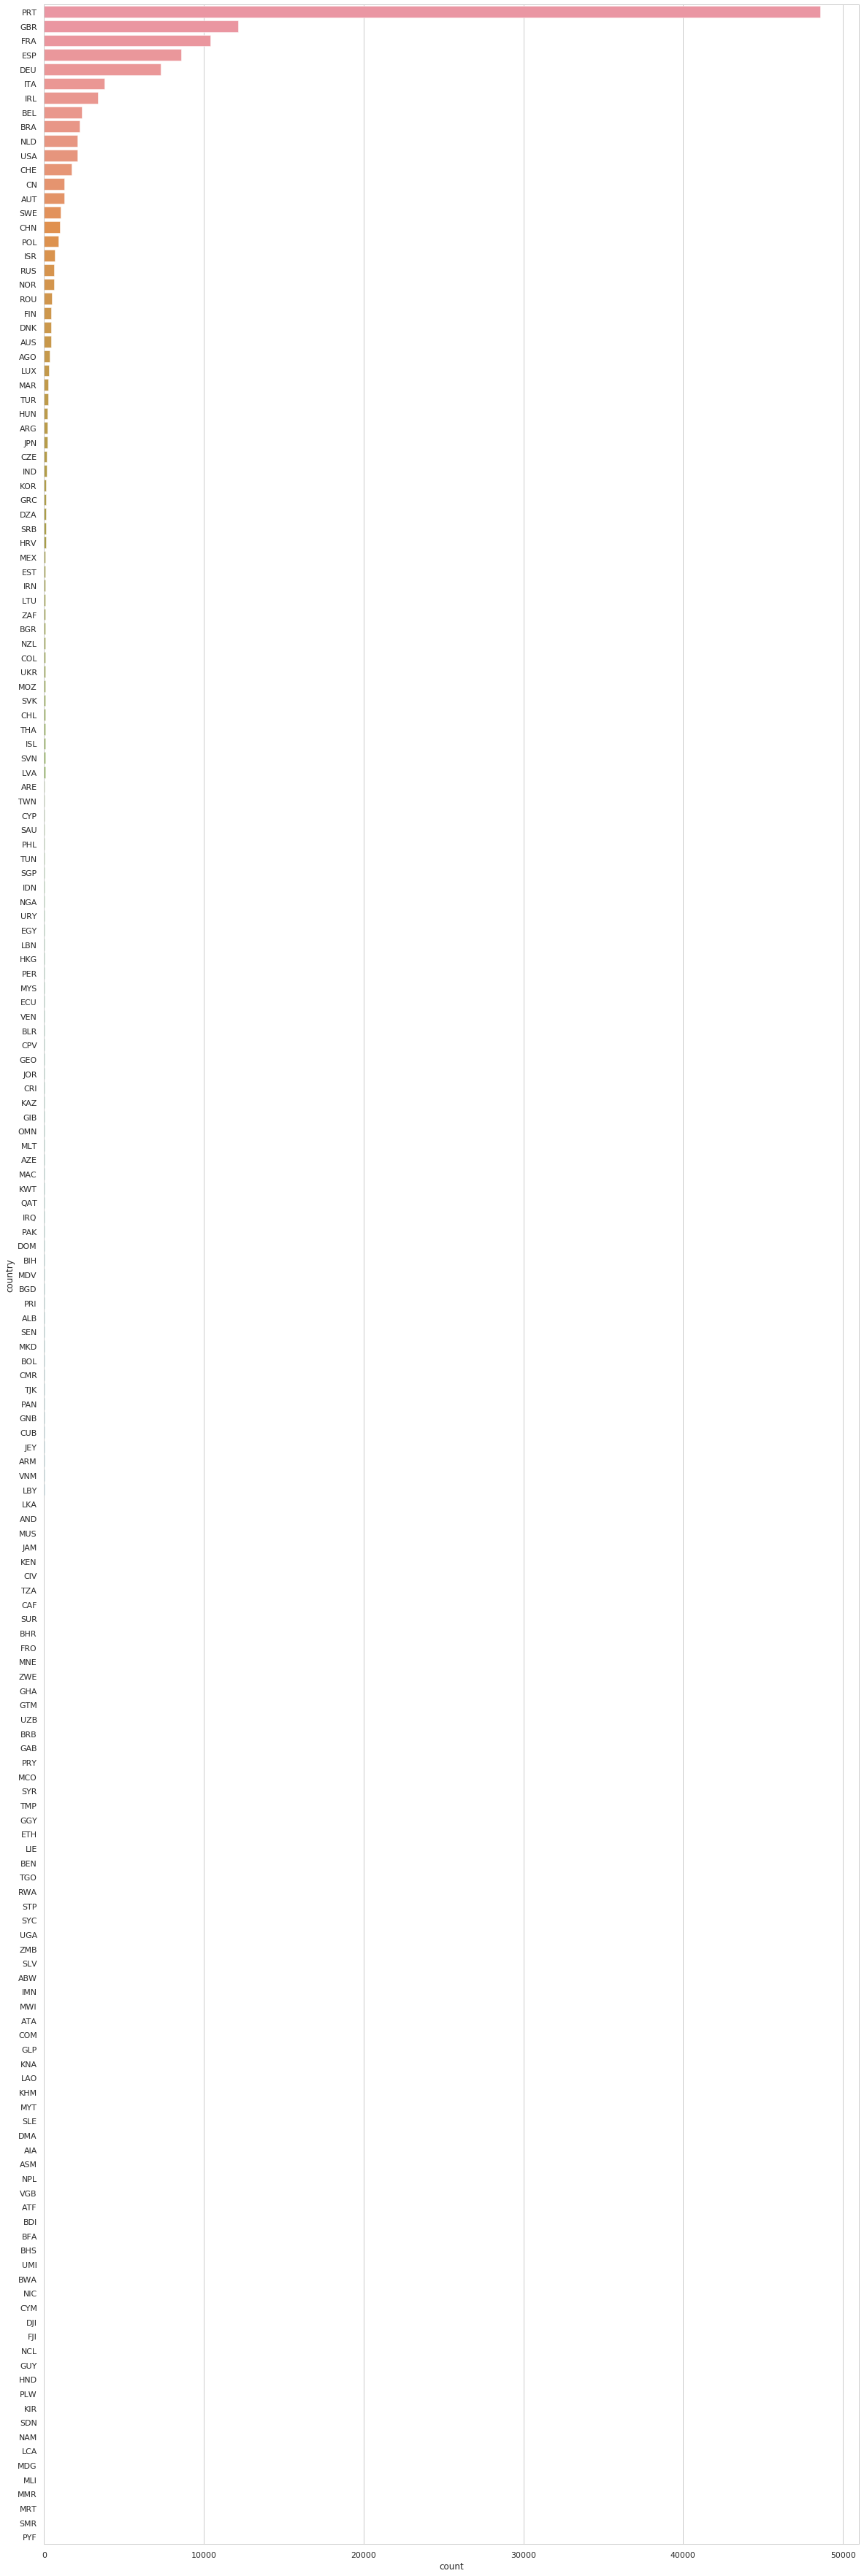

In [17]:
plt.figure(figsize=(20, 64))

countries = df.groupby('country')[['is_canceled']].count().reset_index()
countries.rename(columns={'is_canceled': 'count'}, inplace=True)

countries = countries.sort_values(by='count', ascending=False)
sns.barplot(x=countries['count'], y=countries['country']);

Видим, что есть очень много стран с небольшим кол-вом туристов.  
Попробую в качестве быстрого решения объединить их в одну группу Other.

In [18]:
countries[countries['country']=='DNK']

,country,count
46,DNK,435


In [19]:
small_groups = list(countries[countries['count']<435]['country'].values)

In [20]:
df.loc[df['country'].isin(small_groups)==True, 'country'] = 'Other'

Перейду к корреляции признака с таргетом:

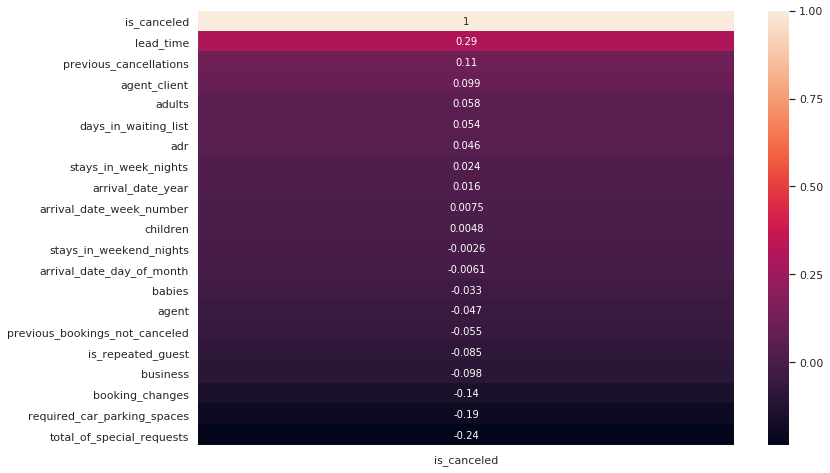

In [21]:
sns.heatmap(df.corr()[['is_canceled']].sort_values(
    by='is_canceled', ascending=False), annot=True);

Довольно высока корреляция с lead_time.  
Посмотрю на распределение этого признака.

In [22]:
def dist_plot(df, feature, target):
    """
    Строит график плотности распределения по каждому из значений
    целевой переменной (до 8 значений)
    """
    
    matplotlib_colors = ['g', 'r', 'b', 'c', 'm', 'y', 'k', 'w']
    plt_colors = dict(zip(range(len(matplotlib_colors)), matplotlib_colors))
    
    for idx, value in enumerate(df[target].unique()):
        sns.kdeplot(df[df[target] == value][feature], label=value, color=plt_colors[idx])
    
    plt.xlim(0)
    plt.title('Распределение {}'.format(feature))
    plt.show()

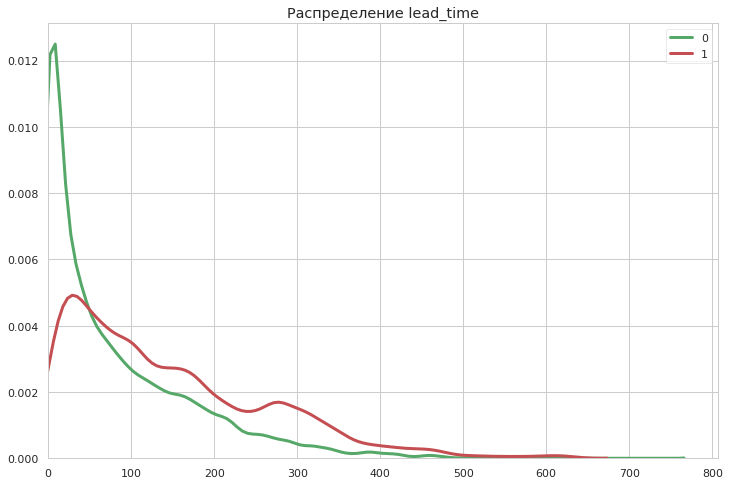

In [23]:
dist_plot(df, 'lead_time', 'is_canceled')

## Подготовка данных для построения моделей

In [24]:
# удалю дубликаты
df.drop_duplicates(inplace=True)

# отделю таргет и признаки
X = df.drop(['is_canceled', 'reservation_status_date'], axis=1) # дату пока прсото удалю
y = df['is_canceled']
            
# воспроизводимость
rs = np.random.seed(0)

# разобью данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rs, stratify=y)
       
print('Доля отмен в трейне: {:.4f}'.format(np.mean(y_train)), end='\n')
print('Доля отмен в тесте: {:.4f}'.format(np.mean(y_test)))

Доля отмен в трейне: 0.2762
Доля отмен в тесте: 0.2762


In [25]:
# закодирую категориальные переменные

label_encoder = LabelEncoder()

for column in X_train.columns[X_train.dtypes == 'object']:
    try:
        X_train[column] = label_encoder.fit_transform(X_train[column])
    except:
        print(column)
        break
    X_test[column] = label_encoder.transform(X_test[column])

In [26]:
# тк бейзлайном будет выступать линейная модель, применю стандартизацию

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Логистическая регрессия

In [27]:
def cross_validation(classifier, X_train, y_train, cv=3, scoring='accuracy'):
    # название модели для красивого вывода
    clf_name = str(classifier)
    clf_name = clf_name[:clf_name.index('(')]
    cv_scores = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv)
    print('Среднее значение \033[1m{}\033[0m для {} на валидации: \033[1m{:.4f}\033[0m'.format(
        scoring, clf_name, np.mean(cv_scores)))
    
def fit_evaluate(classifier, X_train, X_test, y_train, y_test, metric=accuracy_score):
    # название модели для красивого вывода
    clf_name = str(classifier)
    clf_name = clf_name[:clf_name.index('(')]
    
    # название метрики 
    metric_name = str(metric)
    metric_name = metric_name[metric_name.index(' ')+1:metric_name.index(' at')]
    classifier.fit(X_train, y_train)
    predictions = classifier.predict_proba(X_test)[:, 1]
    print('Среднее значение \033[1m{}\033[0m для {} на отложенной выборке: \033[1m{:.4f}\033[0m'.format(
        metric_name, clf_name, metric(y_test, predictions)))

In [28]:
# кросс валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

# создаем экземпляр класса модели
logit = LogisticRegression(random_state=rs)

cross_validation(logit, X_train, y_train, cv=skf, scoring='roc_auc')
fit_evaluate(logit, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для LogisticRegression на валидации: 0.8028
Среднее значение roc_auc_score для LogisticRegression на отложенной выборке: 0.8006


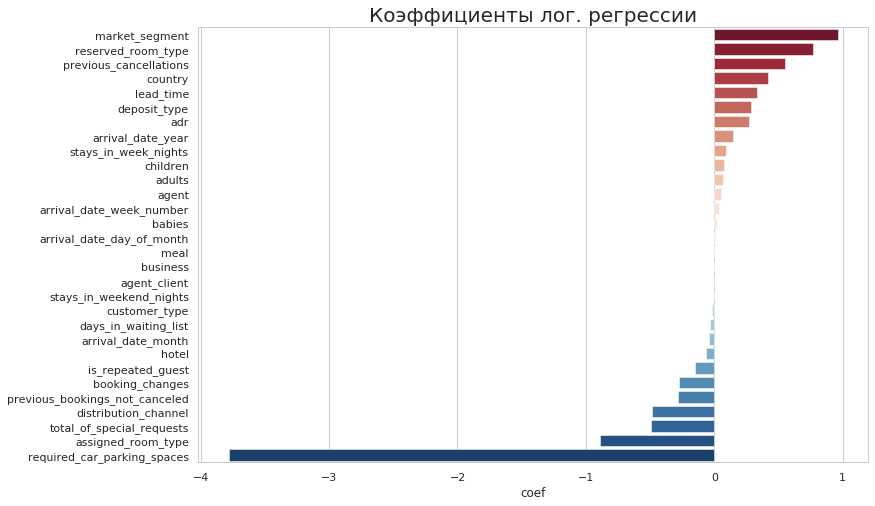

In [29]:
# посмотрим на коэффициенты

coefs = pd.DataFrame(np.transpose(logit.coef_),
             X.columns, columns=['coef']).sort_values(by='coef', ascending=False)

sns.barplot(y=coefs.index, x=coefs['coef'], palette='RdBu')
plt.title('Коэффициенты лог. регрессии', fontsize=20);

In [30]:
preds = logit.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.93      0.86     18860
           1       0.66      0.37      0.48      7196

    accuracy                           0.77     26056
   macro avg       0.73      0.65      0.67     26056
weighted avg       0.76      0.77      0.75     26056



## Random Forest

In [31]:
# кросс валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

# создаем экземпляр класса модели
rf = RandomForestClassifier(random_state=rs, n_jobs=-1)

cross_validation(rf, X_train, y_train, cv=skf, scoring='roc_auc')
fit_evaluate(rf, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для RandomForestClassifier на валидации: 0.9053
Среднее значение roc_auc_score для RandomForestClassifier на отложенной выборке: 0.9086


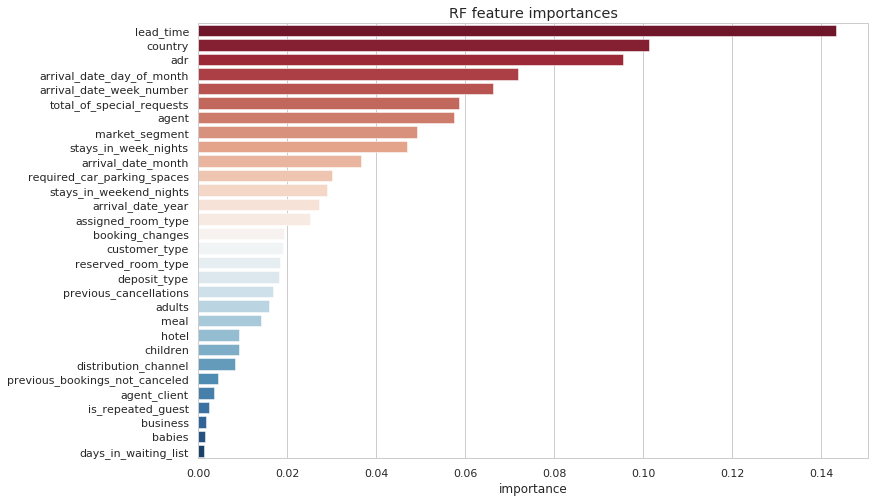

In [32]:
# выведу важность признаков

imp = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x=imp['importance'], y=imp.index, order=imp.index, palette='RdBu')
plt.title('RF feature importances');

In [33]:
preds = rf.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     18860
           1       0.78      0.65      0.71      7196

    accuracy                           0.85     26056
   macro avg       0.82      0.79      0.80     26056
weighted avg       0.85      0.85      0.85     26056



## LightGBM

In [34]:
# кросс валидация
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rs)

# создаем экземпляр класса модели
lgbm = LGBMClassifier(random_state=rs, n_jobs=-1)

cross_validation(lgbm, X_train, y_train, cv=skf, scoring='roc_auc')
fit_evaluate(lgbm, X_train, X_test, y_train, y_test, metric=roc_auc_score)

Среднее значение roc_auc для LGBMClassifier на валидации: 0.9137
Среднее значение roc_auc_score для LGBMClassifier на отложенной выборке: 0.9146


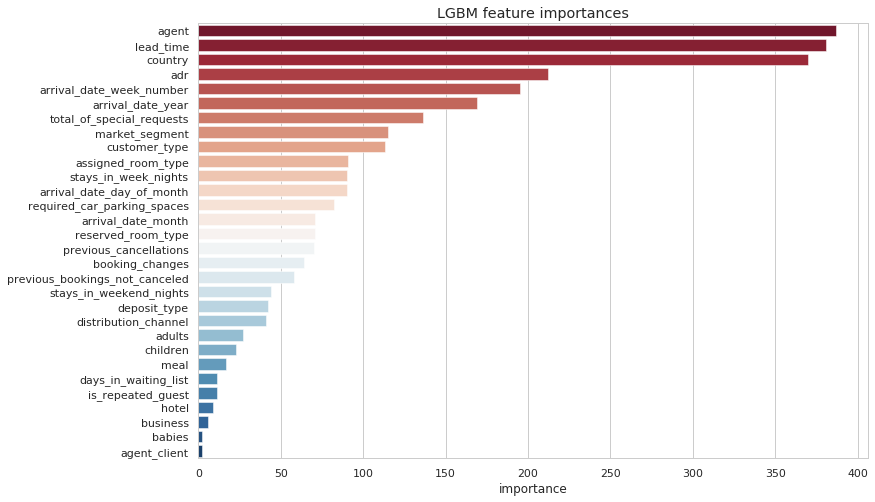

In [35]:
# выведу важность признаков

imp = pd.DataFrame(lgbm.feature_importances_, index=X.columns, columns=['importance'])
imp.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x=imp['importance'], y=imp.index, order=imp.index, palette='RdBu')
plt.title('LGBM feature importances');

In [36]:
preds = lgbm.predict(X_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     18860
           1       0.76      0.67      0.71      7196

    accuracy                           0.85     26056
   macro avg       0.82      0.79      0.80     26056
weighted avg       0.85      0.85      0.85     26056



## TODO: Feature generation, feature selection, hyperparams tuning